# Diffusion Models on Manifold Data

Verification experiments comparing x-prediction, ε-prediction, and v-prediction for diffusion models trained on low-dimensional manifold data embedded in high-dimensional space.

**Setup**: 2D manifold data (two moons or swiss roll) projected to D ∈ {2, 8, 16, 512, 1024} dimensions

**Key test**: D=512 where model is under-complete (D > hidden_dim=256)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.datasets import make_moons, make_swiss_roll

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)

# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


## Data Generation

Generating 2D dataset...
Generated data: x_high shape: torch.Size([10000, 2]), x_low shape: torch.Size([10000, 2]), P shape: (2, 2)
Generated data: x_high shape: torch.Size([5000, 2]), x_low shape: torch.Size([5000, 2]), P shape: (2, 2)
Generating 8D dataset...
Generated data: x_high shape: torch.Size([10000, 8]), x_low shape: torch.Size([10000, 2]), P shape: torch.Size([8, 2])
Generated data: x_high shape: torch.Size([5000, 8]), x_low shape: torch.Size([5000, 2]), P shape: torch.Size([8, 2])
Generating 16D dataset...
Generated data: x_high shape: torch.Size([10000, 16]), x_low shape: torch.Size([10000, 2]), P shape: torch.Size([16, 2])
Generated data: x_high shape: torch.Size([5000, 16]), x_low shape: torch.Size([5000, 2]), P shape: torch.Size([16, 2])
Generating 512D dataset...
Generated data: x_high shape: torch.Size([10000, 512]), x_low shape: torch.Size([10000, 2]), P shape: torch.Size([512, 2])
Generated data: x_high shape: torch.Size([5000, 512]), x_low shape: torch.Size([5000, 

/tmp/ipykernel_27192/3399111067.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'train': (torch.tensor(x_train), torch.tensor(x_train_low), torch.tensor(P_train)),
/tmp/ipykernel_27192/3399111067.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'test': (torch.tensor(x_test), torch.tensor(x_test_low), torch.tensor(P_test))


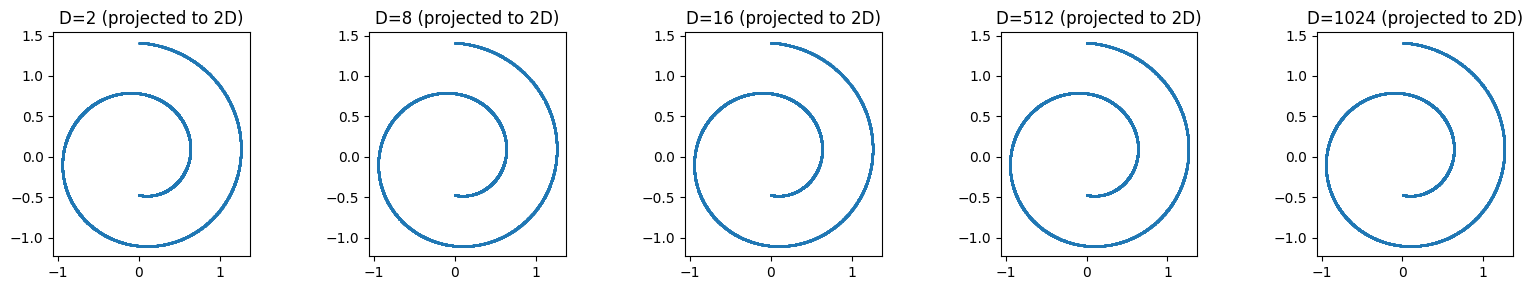


Dataset shapes:
  D=2: torch.Size([10000, 2])
  D=8: torch.Size([10000, 8])
  D=16: torch.Size([10000, 16])
  D=512: torch.Size([10000, 512])
  D=1024: torch.Size([10000, 1024])


In [2]:
def generate_manifold_data(n_samples: int, true_d: int, D: int, noise: float = 0.00, d_type: str = 'other', device: str = 'cpu'):
    """Generate toy manifold data.
    
    Args:
        n_samples: Number of samples
        true_d: True dimension (manifold dimension)
        D: Observed dimension (ambient dimension)
        noise: Noise level for two moons
        d_type: Type of manifold ('two_moons' or 'swiss_roll')
        device: Device for tensors
        
    Returns:
        x_high: High-dimensional data (n_samples, D)
        x_low: Low-dimensional data (n_samples, true_d)
        P: Projection matrix (D, true_d)
    """
    if d_type == 'two_moons':
        x_low, _ = make_moons(n_samples=n_samples, noise=noise)
    else:
        x_low, _ = make_swiss_roll(n_samples=n_samples, noise=noise)
        x_low = x_low[:,[0,2]]/10

    x_low = torch.tensor(x_low, dtype=torch.float32, device=device)

    if D == true_d:
        P = np.eye(D, dtype=np.float32)
        x_high = x_low
    else:
        # Random orthogonal projection: P in R^(D x d), column-orthogonal
        P = torch.randn(D, true_d, dtype=torch.float32)
        P, _ = torch.linalg.qr(P)
        x_high = x_low @ P.T
    
    print(f"Generated data: x_high shape: {x_high.shape}, x_low shape: {x_low.shape}, P shape: {P.shape}")
    
    return x_high, x_low, P


# Generate datasets for different dimensions
n_train = 10000
n_test = 5000
d = 2  # True dimension
dimensions = [2, 8, 16, 512, 1024]

datasets = {}
for D in dimensions:
    print(f"Generating {D}D dataset...")
    x_train, x_train_low, P_train = generate_manifold_data(n_train, d, D)
    x_test, x_test_low, P_test = generate_manifold_data(n_test, d, D)
    
    datasets[D] = {
        'train': (torch.tensor(x_train), torch.tensor(x_train_low), torch.tensor(P_train)),
        'test': (torch.tensor(x_test), torch.tensor(x_test_low), torch.tensor(P_test))
    }

# Visualize 2D data
fig, axes = plt.subplots(1, len(dimensions), figsize=(16, 3))
for idx, D in enumerate(dimensions):
    x_low = datasets[D]['train'][1].numpy()
    axes[idx].scatter(x_low[:, 0], x_low[:, 1], s=1, alpha=0.5)
    axes[idx].set_title(f'D={D} (projected to 2D)')
    axes[idx].set_aspect('equal')
plt.tight_layout()
plt.show()

print(f"\nDataset shapes:")
for D in dimensions:
    x_train = datasets[D]['train'][0]
    print(f"  D={D}: {x_train.shape}")

## Noise Schedule and Visualization

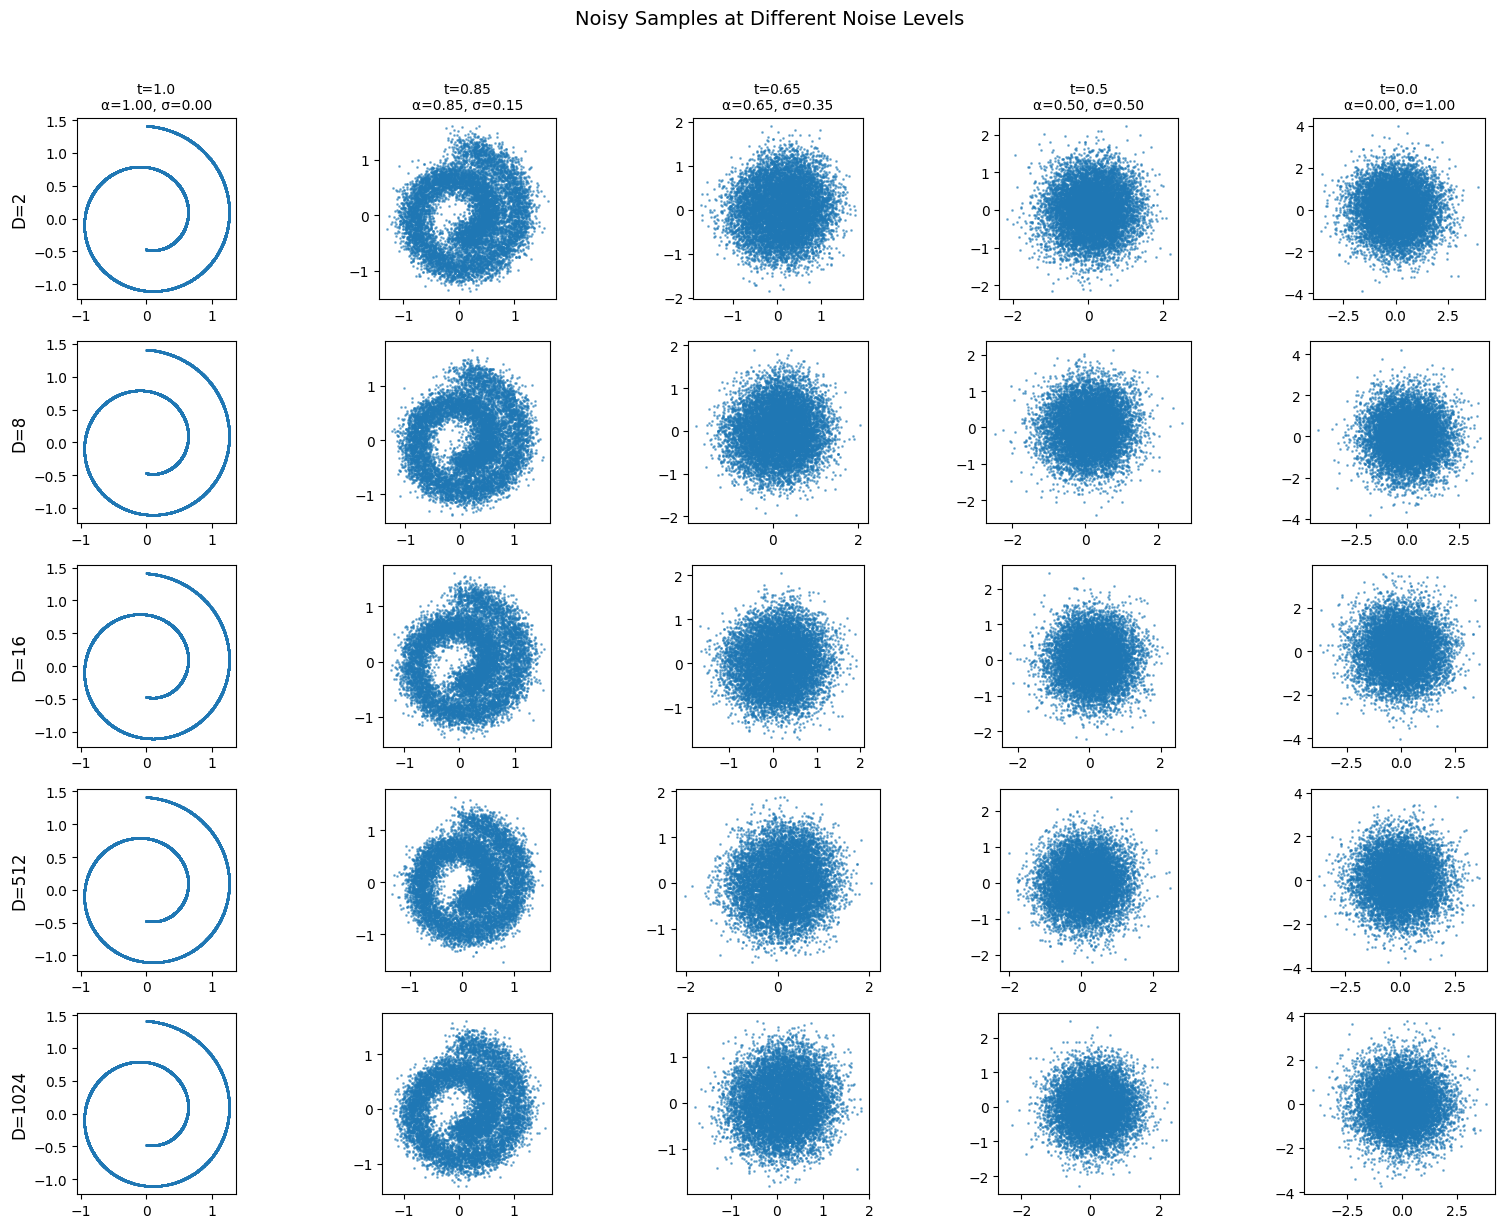

In [3]:
import abc
from torch import Tensor


class Schedule(nn.Module, abc.ABC):
    """Abstract base class for noise schedules."""
    
    @abc.abstractmethod
    def forward(self, t: Tensor) -> tuple[Tensor, Tensor]:
        """Returns (alpha_t, sigma_t) for time t."""
        pass


class LinearSchedule(Schedule):
    """Linear noise schedule: α_t = t, σ_t = 1-t (t=1 clean, t=0 noise)."""

    def forward(self, t: Tensor) -> tuple[Tensor, Tensor]:
        alpha_t = t
        sigma_t = 1 - t
        return alpha_t, sigma_t


# Visualize noise at different time steps
schedule = LinearSchedule()
t_values = [1.0, 0.85, 0.65, 0.5, 0.0]

fig, axes = plt.subplots(len(dimensions), len(t_values), figsize=(16, 12))

for row_idx, D in enumerate(dimensions):
    x_train = datasets[D]['train'][0]
    x_low = datasets[D]['train'][1].numpy()
    
    for col_idx, t in enumerate(t_values):
        t_tensor = torch.tensor([t])
        alpha_t, sigma_t = schedule(t_tensor)
        epsilon = torch.randn_like(x_train)
        x_noisy = alpha_t * x_train + sigma_t * epsilon
        
        # Project back to 2D for visualization
        P = datasets[D]['train'][2].numpy()
        x_noisy_2d = x_noisy.numpy() @ P
        
        axes[row_idx, col_idx].scatter(x_noisy_2d[:, 0], x_noisy_2d[:, 1], s=1, alpha=0.5)
        axes[row_idx, col_idx].set_aspect('equal')
        
        if row_idx == 0:
            axes[row_idx, col_idx].set_title(f't={t}\nα={alpha_t.item():.2f}, σ={sigma_t.item():.2f}', fontsize=10)
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(f'D={D}', fontsize=12)

plt.suptitle('Noisy Samples at Different Noise Levels', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## Model Definition

In [4]:
class predDenoiser(nn.Module):
    """Wraps backbone with schedule and prediction type (x, ε, or v)."""

    def __init__(self, backbone: nn.Module, schedule: Schedule, denoiser_type: str):
        super().__init__()
        self.backbone = backbone
        self.schedule = schedule
        self.denoiser_type = denoiser_type

    def forward(self, x_t: Tensor, t: Tensor, **kwargs):
        alpha_t, sigma_t = self.schedule(t)
        while alpha_t.ndim < x_t.ndim:
            alpha_t, sigma_t = alpha_t[..., None], sigma_t[..., None]
        return self.backbone(x_t, t, **kwargs)


class Loss(nn.Module):
    """V-loss for all prediction types (converts predictions to velocity)."""

    def __init__(self, l_type: str):
        super().__init__()
        self.l_type = l_type
        self.t_eps = 0.05

    def sample_t(self, n, device=None):
        """Returns the time prior p(t)."""
        return torch.rand(n, 1, device=device)

    def forward(self, denoiser, x: Tensor, **kwargs) -> Tensor:
        """Compute v-loss.
        
        Args:
            denoiser: The denoiser model
            x: A clean vector x, with shape (B, ...)
            kwargs: Optional keyword arguments

        Returns:
            The MSE loss between v_pred and v_target
        """
        B, *_ = x.shape
        t = self.sample_t(B, device=x.device)
        alpha_t, sigma_t = denoiser.schedule(t)
        while alpha_t.ndim < x.ndim:
            alpha_t, sigma_t = alpha_t[..., None], sigma_t[..., None]

        epsilon = torch.randn_like(x)
        x_t = alpha_t * x + sigma_t * epsilon
        v_t = (x - x_t) / sigma_t.clamp_min(self.t_eps)

        # Get raw prediction from backbone
        raw_pred = denoiser.backbone(x_t, t)

        # Convert prediction to velocity
        if denoiser.denoiser_type == 'x':
            v_pred = (raw_pred - x_t) / sigma_t.clamp_min(self.t_eps)
        elif denoiser.denoiser_type == 'eps':
            v_pred = (x_t - raw_pred) / alpha_t.clamp_min(self.t_eps)
        elif denoiser.denoiser_type == 'v':
            v_pred = raw_pred
        
        target = v_t
        loss = ((v_pred - target)**2).mean()
        return loss


class MLP(nn.Module):
    """5-layer MLP backbone with simple time encoding."""
    
    def __init__(self, dim):
        super().__init__()
        self.time_encoder = nn.Sequential(
            nn.Linear(1, 20), nn.ReLU(),
        )
        self.net = nn.Sequential(
            nn.Linear(dim + 20, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, dim)
        )

    def forward(self, x, t):
        t_emb = self.time_encoder(t)
        out = self.net(torch.cat((x, t_emb), dim=-1))
        return out


def create_denoiser(pred_type: str, D: int):
    """Create a denoiser with specified prediction type.
    
    Args:
        pred_type: 'x', 'eps', or 'v'
        D: Observed dimension
        
    Returns:
        Denoiser model
    """
    backbone = MLP(dim=D)
    schedule = LinearSchedule()
    denoiser = predDenoiser(backbone=backbone, schedule=schedule, denoiser_type=pred_type)
    return denoiser

## Training

In [5]:
def train_toy_diffusion(
    denoiser: nn.Module,
    loss_fn: nn.Module,
    dataloader: DataLoader,
    n_epochs: int = 200,
    lr: float = 1e-3,
    device: str = 'cuda'
):
    """Train diffusion model on toy data.
    
    Args:
        denoiser: Denoiser model
        loss_fn: Loss function
        dataloader: Training data loader
        n_epochs: Number of training epochs
        lr: Learning rate
        device: Device to train on
        
    Returns:
        losses: List of epoch losses
    """
    denoiser = denoiser.to(device)
    optimizer = torch.optim.AdamW(denoiser.parameters(), lr=lr)
    
    losses = []
    pbar = tqdm(range(n_epochs), desc="Training")
    
    for epoch in pbar:
        epoch_losses = []
        for batch in dataloader:
            x = batch[0].to(device)
            loss = loss_fn(denoiser, x, cond=None)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        
        avg_loss = np.mean(epoch_losses)
        losses.append(avg_loss)
        pbar.set_postfix({'loss': f'{avg_loss:.4f}'})
    
    return losses

## Train Models

In [6]:
batch_size = 1024
n_epochs = 3000
lr = 1.0e-3

D_MAINS = [2, 8, 16, 512, 1024]
pred_types = ['v', 'x', 'eps']

results = {}
for D_MAIN in D_MAINS:
    x_train = datasets[D_MAIN]['train'][0]
    train_dataset = TensorDataset(x_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    print(f"Training on D={D_MAIN} with {len(train_dataset)} samples\n")

    for pred_type in pred_types:
        print(f"\n{'='*60}")
        print(f"Training {pred_type}-prediction")
        print(f"{'='*60}")

        denoiser = create_denoiser(pred_type, D=D_MAIN)
        loss_fn = Loss(l_type=pred_type)

        losses = train_toy_diffusion(
            denoiser=denoiser,
            loss_fn=loss_fn,
            dataloader=train_loader,
            n_epochs=n_epochs,
            lr=lr,
            device=device
        )

        results[f"{D_MAIN}_{pred_type}"] = {
            'denoiser': denoiser,
            'losses': losses
        }

        print(f"Final loss: {losses[-1]:.4f}")

    print("\nTraining complete!")

Training on D=2 with 10000 samples


Training v-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.9220

Training x-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.9302

Training eps-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.9416

Training complete!
Training on D=8 with 10000 samples


Training v-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.2291

Training x-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.2313

Training eps-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.2446

Training complete!
Training on D=16 with 10000 samples


Training v-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.1175

Training x-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.1162

Training eps-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.1690

Training complete!
Training on D=512 with 10000 samples


Training v-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.6688

Training x-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.0037

Training eps-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 26.3773

Training complete!
Training on D=1024 with 10000 samples


Training v-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.8205

Training x-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 0.0019

Training eps-prediction


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Final loss: 33.7540

Training complete!


## Training Curves

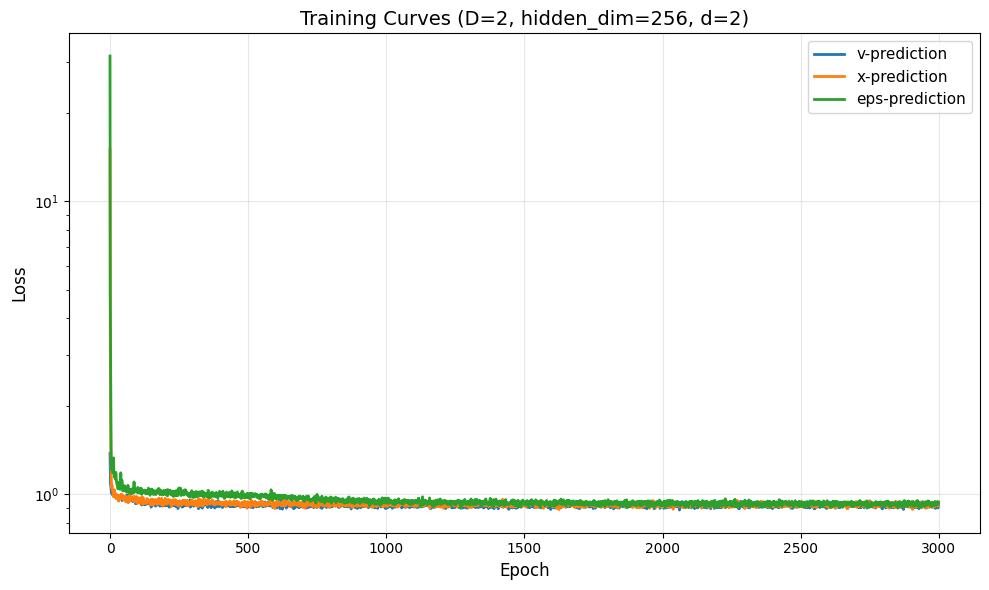

Final training losses:
  v-prediction: 0.9220
  x-prediction: 0.9302
  eps-prediction: 0.9416


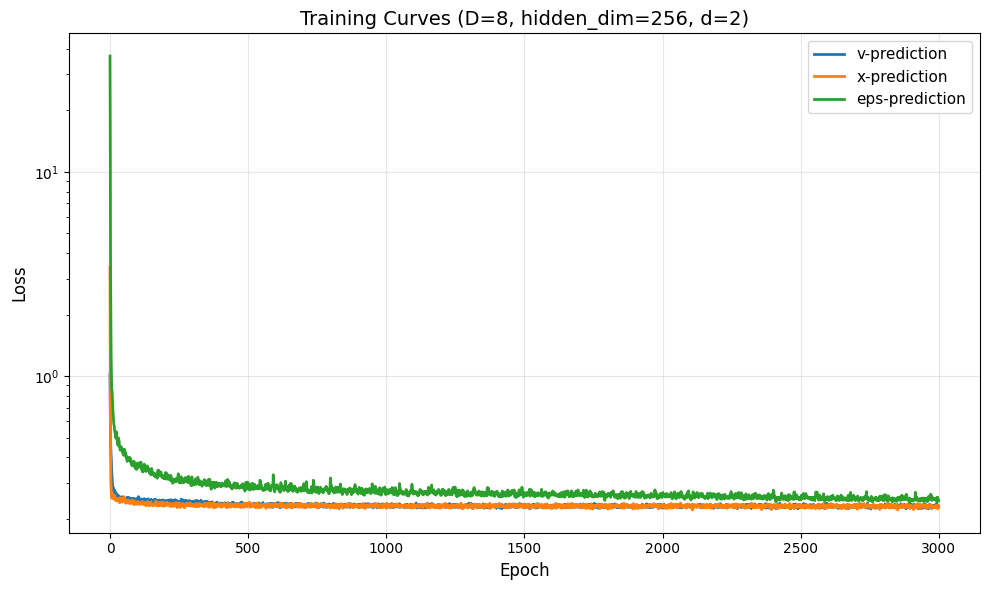

Final training losses:
  v-prediction: 0.2291
  x-prediction: 0.2313
  eps-prediction: 0.2446


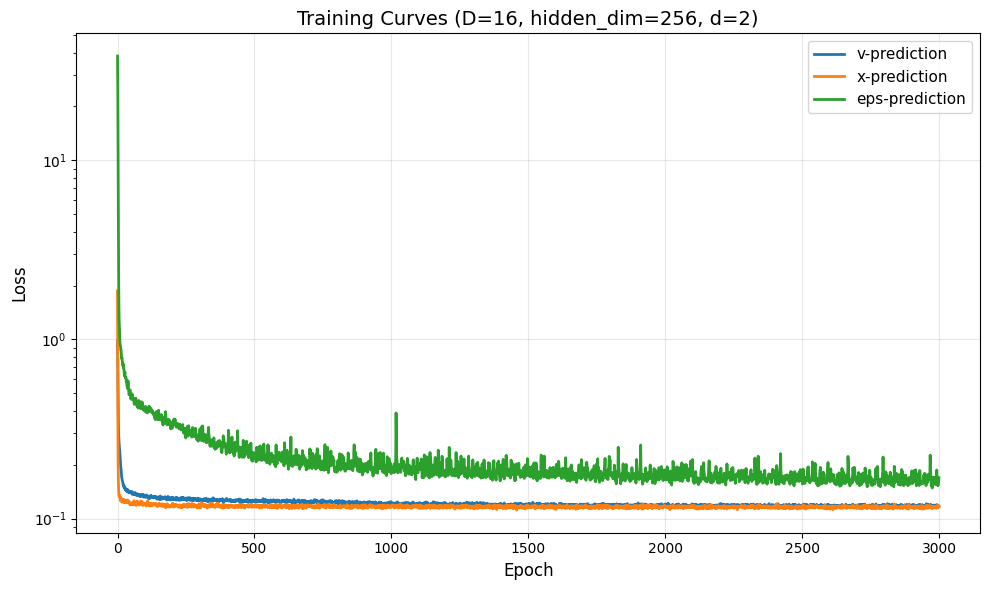

Final training losses:
  v-prediction: 0.1175
  x-prediction: 0.1162
  eps-prediction: 0.1690


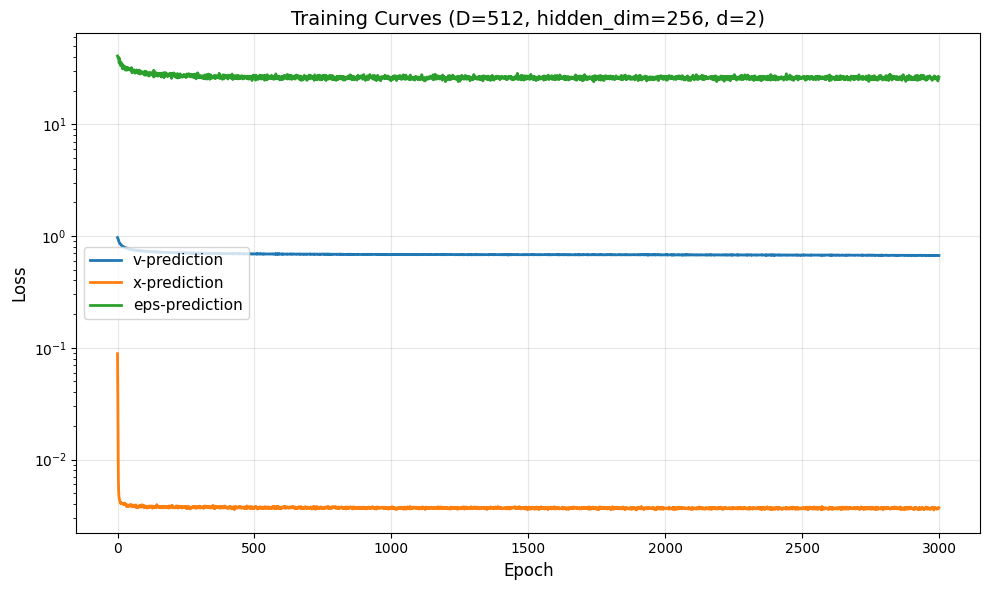

Final training losses:
  v-prediction: 0.6688
  x-prediction: 0.0037
  eps-prediction: 26.3773


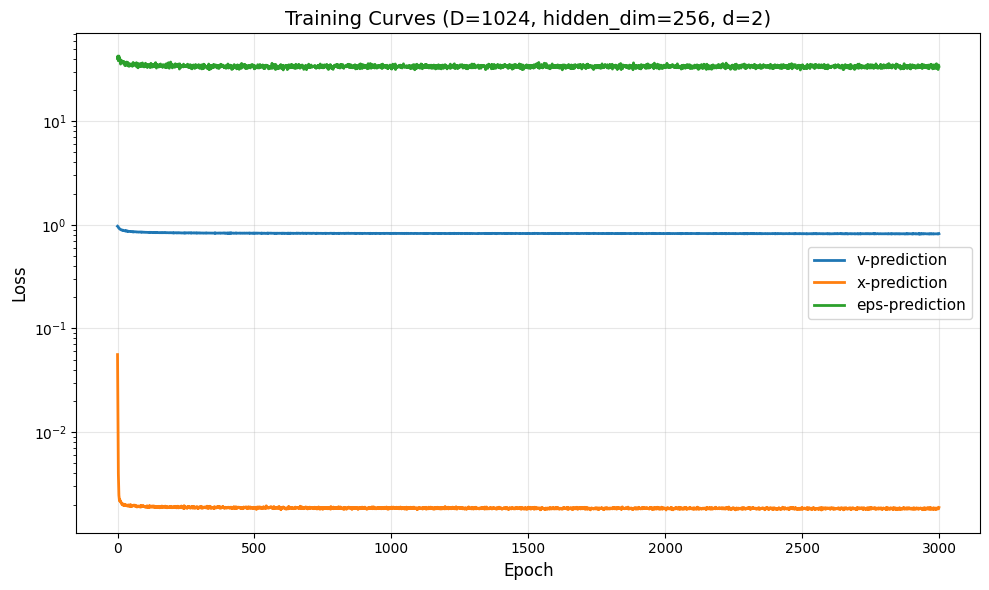

Final training losses:
  v-prediction: 0.8205
  x-prediction: 0.0019
  eps-prediction: 33.7540


In [7]:
for D_MAIN in D_MAINS:
    plt.figure(figsize=(10, 6))
    for pred_type in pred_types:
        losses = results[f"{D_MAIN}_{pred_type}"]['losses']
        plt.plot(losses, label=f'{pred_type}-prediction', linewidth=2)
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title(f'Training Curves (D={D_MAIN}, hidden_dim=256, d=2)', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(alpha=0.3)
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    print("Final training losses:")
    for pred_type in pred_types:
        final_loss = results[f"{D_MAIN}_{pred_type}"]['losses'][-1]
        print(f"  {pred_type}-prediction: {final_loss:.4f}")

## Sampling

In [8]:
class Sampling():
    """Euler ODE sampler using velocity formulation."""
    
    def __init__(
        self,
        denoiser,
        shape,
        start: float = 0.0,
        stop: float = 1.0,
        steps: int = 64,
        silent: bool = False,
        dtype = None,
        device = None,
    ):
        self.denoiser = denoiser
        self.timesteps = torch.linspace(start, stop, steps, dtype=dtype, device=device)
        self.silent = silent
        self.t_eps = 0.05
        self.init_x = torch.randn(shape, dtype=dtype, device=device)

    @torch.no_grad()
    def __call__(self, x0: Tensor, **kwargs) -> Tensor:
        x_t = x0
        for i in tqdm(range(len(self.timesteps) - 1), desc="Sampling", disable=self.silent):
            t = self.timesteps[i]
            s = self.timesteps[i + 1]
            x_t = self.step(x_t, t=t, s=s, **kwargs)
        return x_t

    def step(self, x_t: Tensor, t: Tensor, s: Tensor, **kwargs) -> Tensor:
        """Euler ODE step using velocity formulation.

        Arguments:
            x_t: The current tensor x_t
            t: The current time t
            s: The target time s
            kwargs: Optional keyword arguments

        Returns:
            The new tensor x_s
        """
        t = t.expand_as(x_t[..., 0])
        s = s.expand_as(x_t[..., 0])

        alpha_t, sigma_t = self.denoiser.schedule(t)

        while alpha_t.ndim < x_t.ndim:
            alpha_t, sigma_t = alpha_t[..., None], sigma_t[..., None]
        while t.ndim < x_t.ndim:
            t = t[..., None]
            s = s[..., None]

        raw_pred = self.denoiser.backbone(x_t, t, **kwargs)
        
        if self.denoiser.denoiser_type == 'x':
            v_pred = (raw_pred - x_t) / (sigma_t).clamp_min(self.t_eps)
        elif self.denoiser.denoiser_type == 'eps':
            v_pred = (x_t - raw_pred) / alpha_t.clamp_min(self.t_eps)
        elif self.denoiser.denoiser_type == 'v':
            v_pred = raw_pred
        else:
            raise ValueError(f"Unknown denoiser type: {self.denoiser.denoiser_type}")

        return x_t + v_pred * (s - t)


def sample_toy_diffusion(
    denoiser: nn.Module,
    n_samples: int,
    dim: int,
    n_steps: int = 256,
    device: str = 'cuda'
):
    """Sample from trained toy diffusion model.
    
    Args:
        denoiser: Trained denoiser model
        n_samples: Number of samples to generate
        dim: Observed dimension
        n_steps: Number of sampling steps
        device: Device to use
    """
    denoiser = denoiser.to(device)
    
    sampler = Sampling(
        denoiser=denoiser, 
        shape=(n_samples, dim), 
        steps=n_steps, 
        device=device
    )
    
    x0 = sampler.init_x
    x1 = sampler(x0)
    x1 = x1.reshape(n_samples, dim)

    return x1.cpu()


# Generate samples from all models
samples = {}
for D_MAIN in D_MAINS:
    n_samples = 2000
    n_steps = 51

    for pred_type in pred_types:
        print(f"Sampling from {pred_type}-prediction (D={D_MAIN})...")
        denoiser = results[f"{D_MAIN}_{pred_type}"]['denoiser']
        samples[f"{D_MAIN}_{pred_type}"] = sample_toy_diffusion(
            denoiser=denoiser,
            n_samples=n_samples,
            dim=D_MAIN,
            n_steps=n_steps,
            device=device
        )

    print("Sampling complete!")

Sampling from v-prediction (D=2)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from x-prediction (D=2)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from eps-prediction (D=2)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling complete!
Sampling from v-prediction (D=8)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from x-prediction (D=8)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from eps-prediction (D=8)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling complete!
Sampling from v-prediction (D=16)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from x-prediction (D=16)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from eps-prediction (D=16)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling complete!
Sampling from v-prediction (D=512)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from x-prediction (D=512)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from eps-prediction (D=512)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling complete!
Sampling from v-prediction (D=1024)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from x-prediction (D=1024)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling from eps-prediction (D=1024)...


Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling complete!


## Visualization

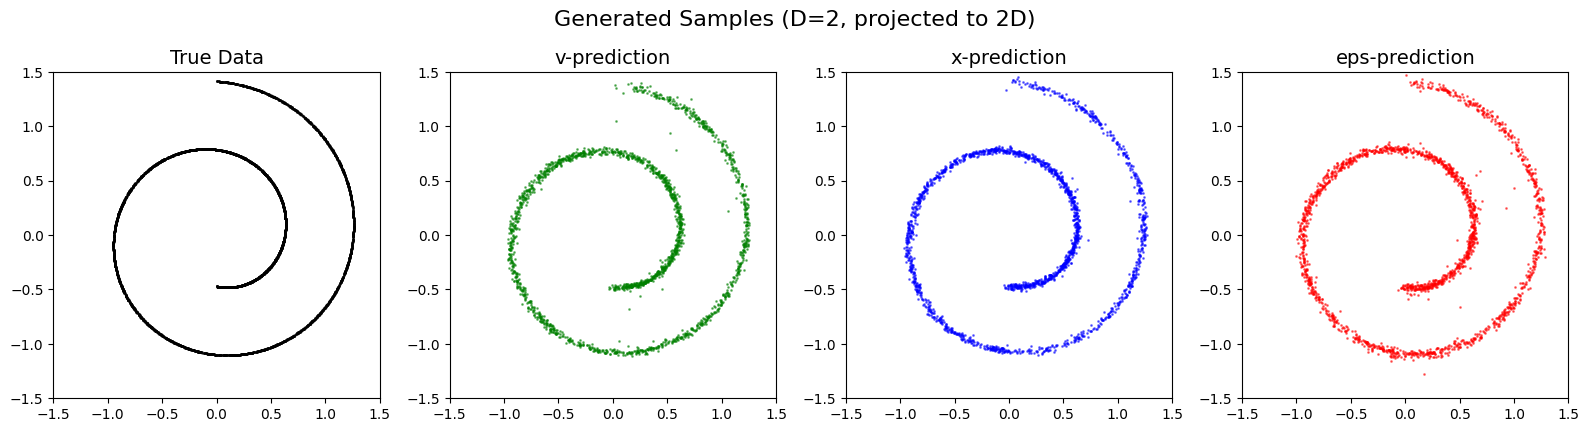

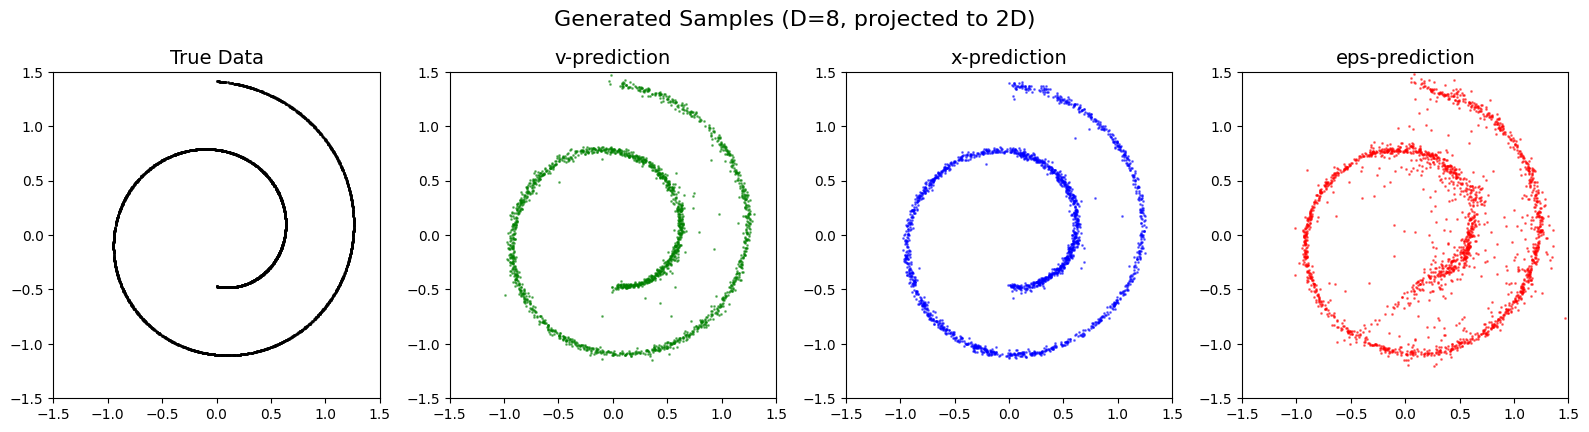

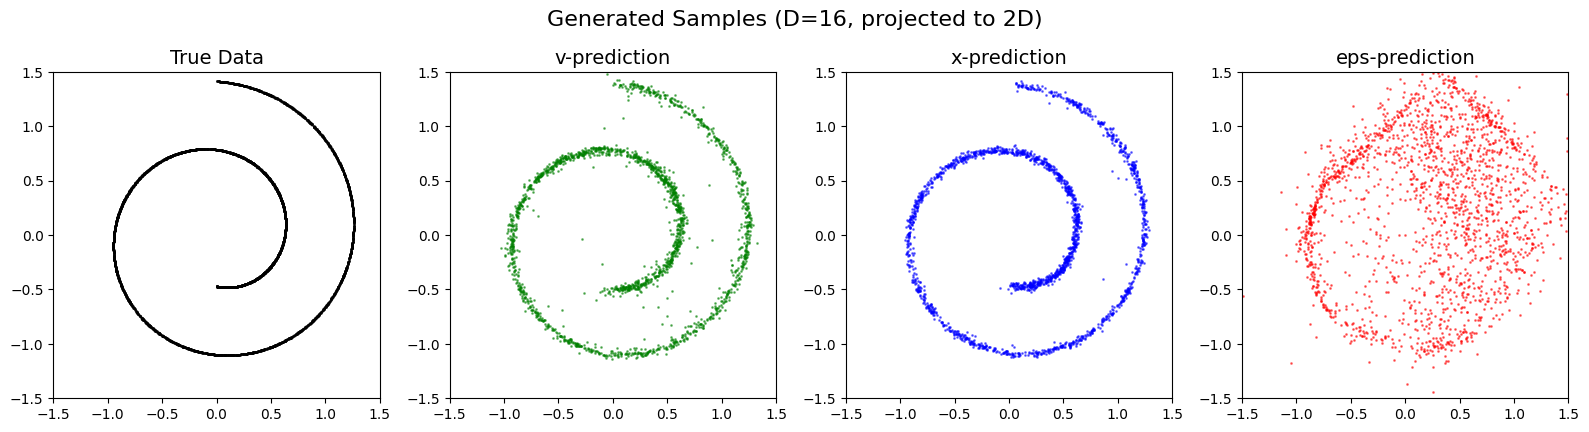

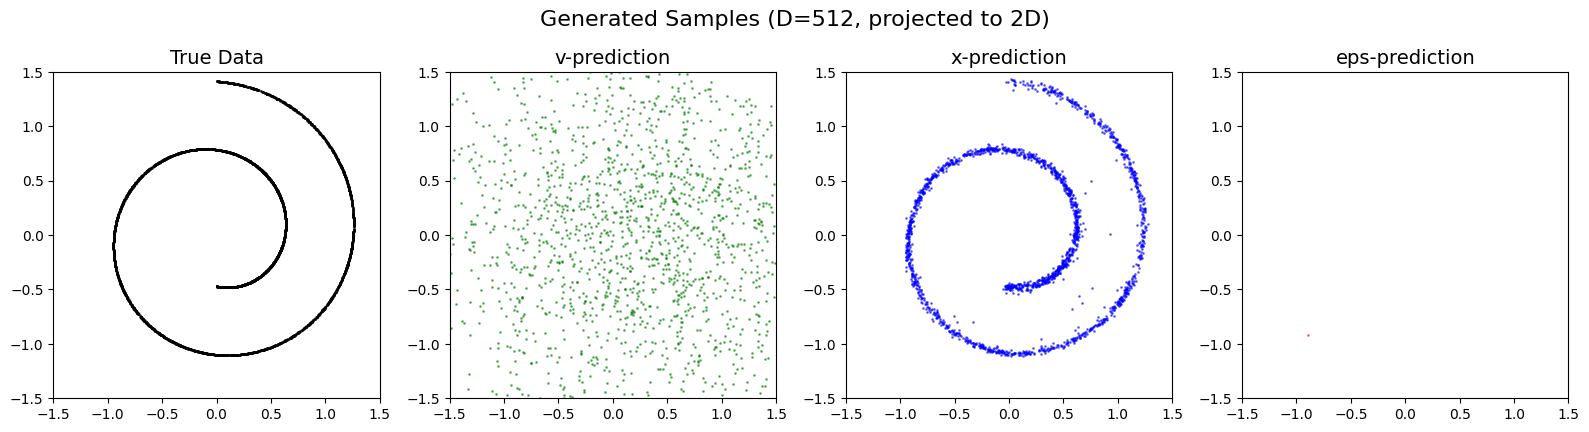

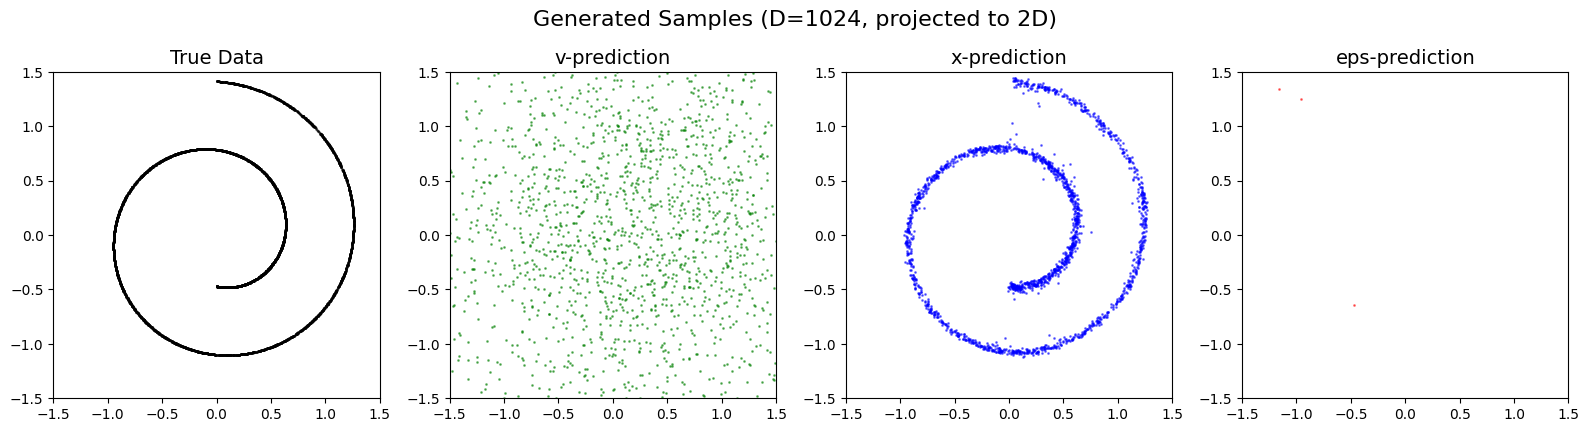

In [9]:
# Project samples to 2D
samples_2d = {}
for D_MAIN in D_MAINS:
    for pred_type in pred_types:
        P = datasets[D_MAIN]['train'][2].numpy()
        samples_high = samples[f"{D_MAIN}_{pred_type}"].numpy()
        samples_2d[f"{D_MAIN}_{pred_type}"] = samples_high @ P

# Plot samples
colors = {'x': 'blue', 'eps': 'red', 'v': 'green'}
for D_MAIN in D_MAINS:
    fig, axes = plt.subplots(1, 4, figsize=(16, 4), width_ratios=[1, 1, 1, 1])
    
    x_test_low = datasets[D_MAIN]['test'][1].numpy()

    # True data
    axes[0].scatter(x_test_low[:, 0], x_test_low[:, 1], s=1, alpha=0.5, c='black')
    axes[0].set_title('True Data', fontsize=14)
    axes[0].set_aspect('equal')
    axes[0].set_xlim(-1.5, 1.5)
    axes[0].set_ylim(-1.5, 1.5)

    for idx, pred_type in enumerate(pred_types):
        s = samples_2d[f"{D_MAIN}_{pred_type}"]
        axes[idx + 1].scatter(s[:, 0], s[:, 1], s=1, alpha=0.5, c=colors[pred_type])
        axes[idx + 1].set_title(f'{pred_type}-prediction', fontsize=14)
        axes[idx + 1].set_aspect('equal')
        axes[idx + 1].set_xlim(-1.5, 1.5)
        axes[idx + 1].set_ylim(-1.5, 1.5)

    plt.suptitle(f'Generated Samples (D={D_MAIN}, projected to 2D)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()